In [1]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('../NIFTY50_all.csv')

In [3]:
from datetime import datetime
from sklearn.impute import SimpleImputer
df['Date'] = [datetime.strptime(x, '%Y-%m-%d') for x in df['Date']]
df1 = df.drop(['Trades', 'Deliverable Volume', 'Series'], axis=1)
ls1 = ['MUNDRAPORT', 'UTIBANK', 'BAJAUTOFIN', 'BHARTI', 'HEROHONDA',
       'HINDALC0', 'HINDLEVER', 'INFOSYSTCH', 'JSWSTL', 'KOTAKMAH', 'TELCO',
       'TISCO', 'UNIPHOS', 'SESAGOA', 'SSLT', 'ZEETELE']
ls2 = ['ADANIPORTS', 'AXISBANK', 'BAJFINANCE', 'BHARTIARTL', 'HEROMOTOCO',
       'HINDALCO', 'HINDUNILVR', 'INFY', 'JSWSTEEL', 'KOTAKBANK', 'TATAMOTORS',
       'TATASTEEL', 'UPL', 'VEDL', 'VEDL', 'ZEEL']
df1['Symbol'] = df1['Symbol'].replace(ls1, ls2)
df1['Symbol'] = pd.Categorical(df1['Symbol'])

In [4]:
df2 = pd.get_dummies(data=df1, drop_first=True)
df2['Date']=df2['Date'].map(datetime.toordinal)
imp = SimpleImputer()
p = imp.fit_transform(df2)
df1['%Deliverble'] = p[:, 10]
df1.to_csv('cleaned.csv')

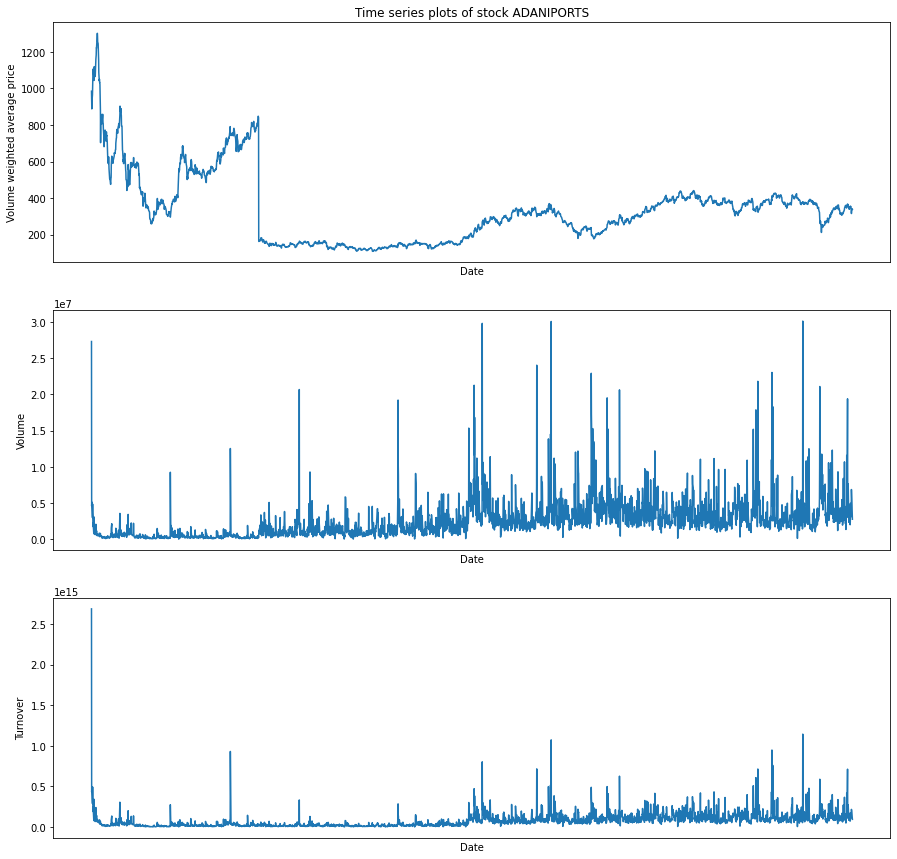

In [5]:
import matplotlib.pyplot as plt
names = df1['Symbol'].cat.categories
example = df1[df1['Symbol'] == names[0]]
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].plot(example['Date'], example['VWAP'])
ax[0].set_xticks([])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Volume weighted average price')
ax[1].plot(example['Date'], example['Volume'])
ax[1].set_xticks([])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume')
ax[2].plot(example['Date'], example['Turnover'])
ax[2].set_xticks([])
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Turnover')
ax[0].set_title('Time series plots of stock %s' % names[0])
plt.savefig('p1.png')

In [6]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
ls0 = []
for i in names:
    subdf = df1[df1['Symbol'] == i]
    ls0.append(ndiffs(subdf['VWAP'], test='adf'))
ls0  # Most values are 1
max(ls0) # We only need 1st order differencing

1

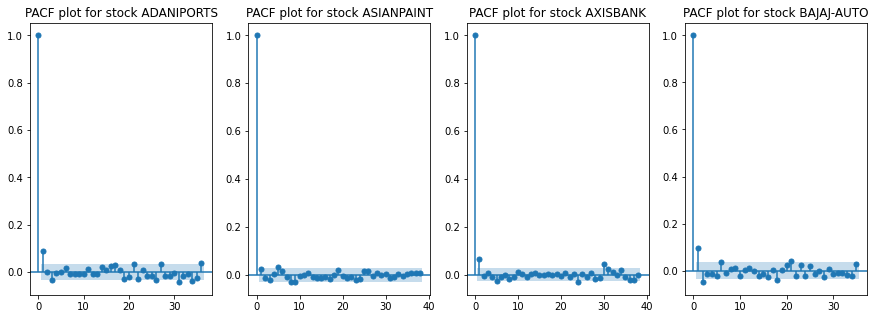

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    subdf = df1[df1['Symbol'] == names[i]]
    plot_pacf(subdf['VWAP'].diff().dropna(), ax=ax[i])
    ax[i].set_title('PACF plot for stock %s' % names[i])
plt.savefig('p2.png')

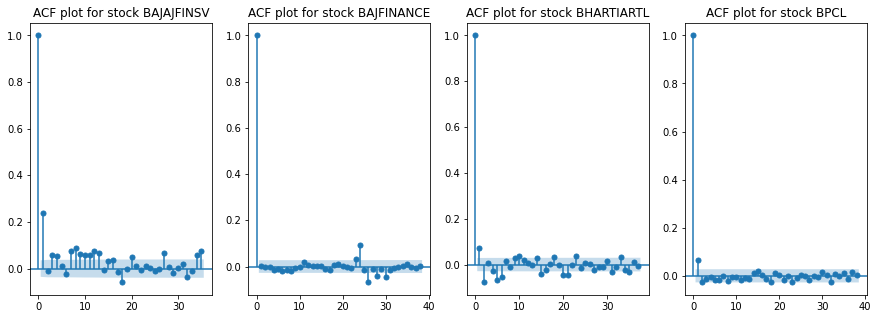

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    subdf = df1[df1['Symbol'] == names[i+4]]
    plot_acf(subdf['VWAP'].diff().dropna(), ax=ax[i])
    ax[i].set_title('ACF plot for stock %s' % names[i+4])
plt.savefig('p3.png')

In [13]:
mlist = []
flist = []
for i in names:
    subdf = df1[df1['Symbol'] == i]
    m = ARIMA(list(subdf['VWAP']), order=(1, 1, 1))
    mlist.append(m)
    flist.append(m.fit(disp=0))
for i in range(5):
    print(flist[i].summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3178
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13340.537
Method:                       css-mle   S.D. of innovations             16.100
Date:                Thu, 12 Nov 2020   AIC                          26689.074
Time:                        12:27:49   BIC                          26713.330
Sample:                             1   HQIC                         26697.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2048      0.314     -0.652      0.514      -0.820       0.411
ar.L1.D.y      0.1049      0.151      0.694      0.488      -0.192       0.401
ma.L1.D.y     -0.0156      0.152     -0.103      0.9

In [43]:
mlist0 = []
flist0 = []
for i in names:
    subdf = df1[df1['Symbol'] == i]
    m = ARIMA(list(subdf['VWAP']), order=(1, 1, 0))
    mlist0.append(m)
    flist0.append(m.fit(disp=0))
for i in range(5):
    print(flist0[i].summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3178
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -13340.542
Method:                       css-mle   S.D. of innovations             16.100
Date:                Thu, 12 Nov 2020   AIC                          26687.084
Time:                        13:23:46   BIC                          26705.276
Sample:                             1   HQIC                         26693.609
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2048      0.314     -0.653      0.514      -0.819       0.410
ar.L1.D.y      0.0894      0.018      5.057      0.000       0.055       0.124
                                    Roots           

In [21]:
includema = []
for i in range(50):
    includema.append(flist0[i].aic > flist[i].aic)
pd.value_counts(includema)

True     28
False    22
dtype: int64

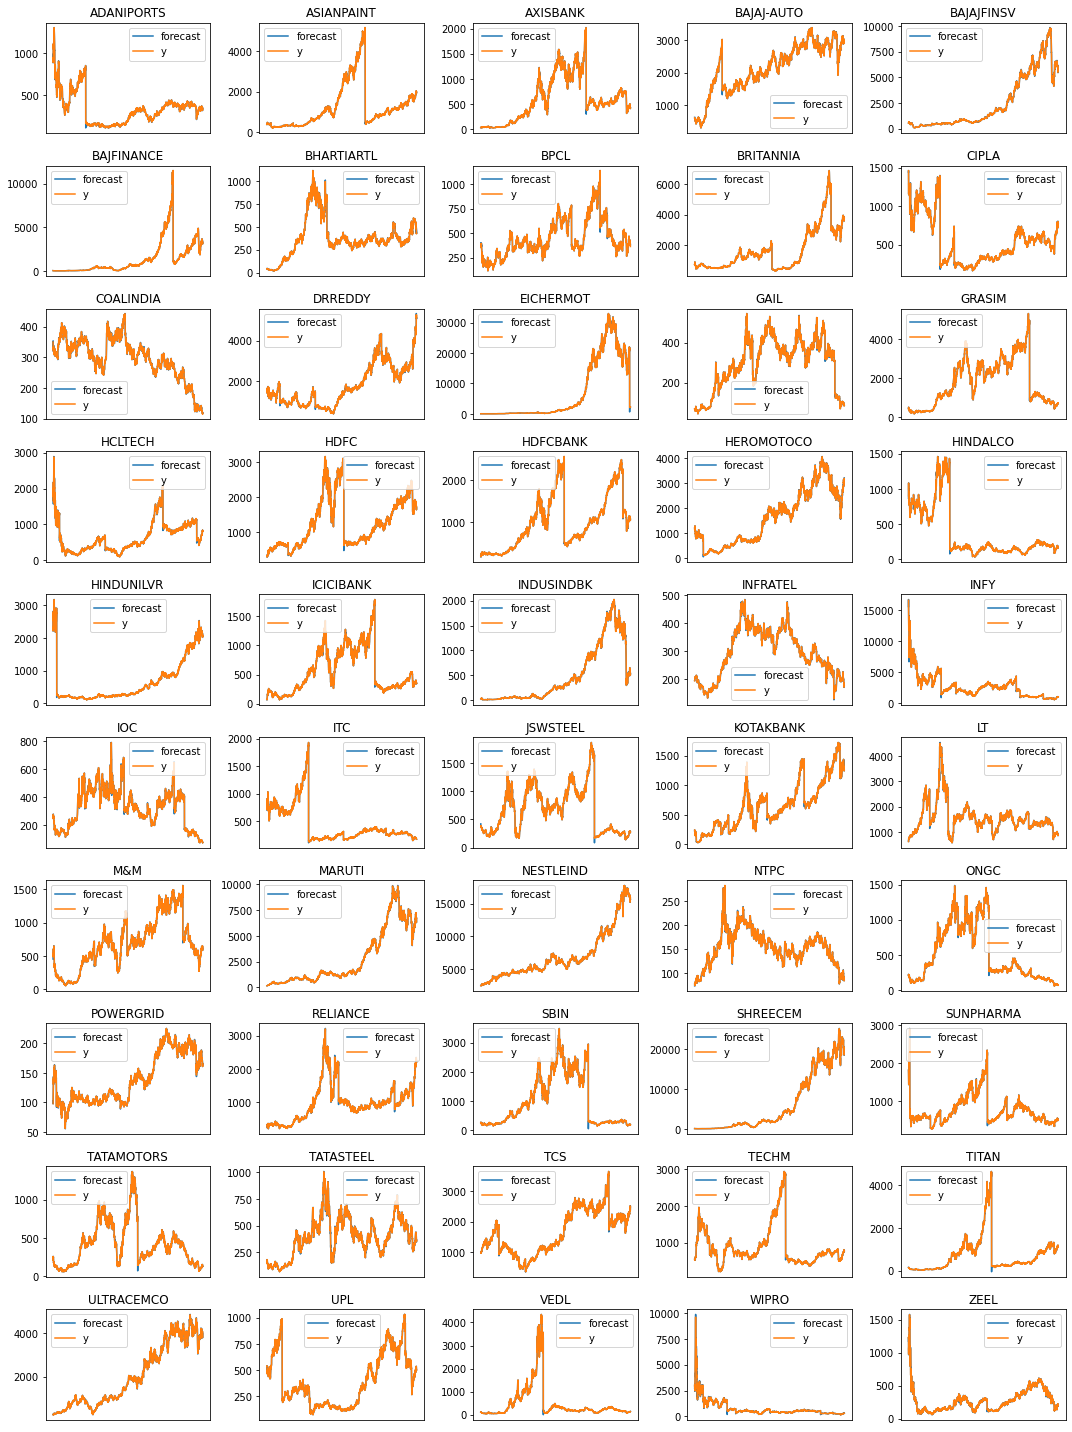

In [34]:
fig, ax = plt.subplots(10, 5, figsize=(15, 20))
for i in range(50):
    if(includema):
        flist[i].plot_predict(dynamic=False, ax=ax[i // 5, i % 5])
    else:
        flist0[i].plot_predict(dynamic=False, ax=ax[i // 5, i % 5])
    ax[i // 5, i % 5].set_title(names[i])
    ax[i // 5, i % 5].set_xticks([])
fig.tight_layout()
plt.savefig('p4.png')

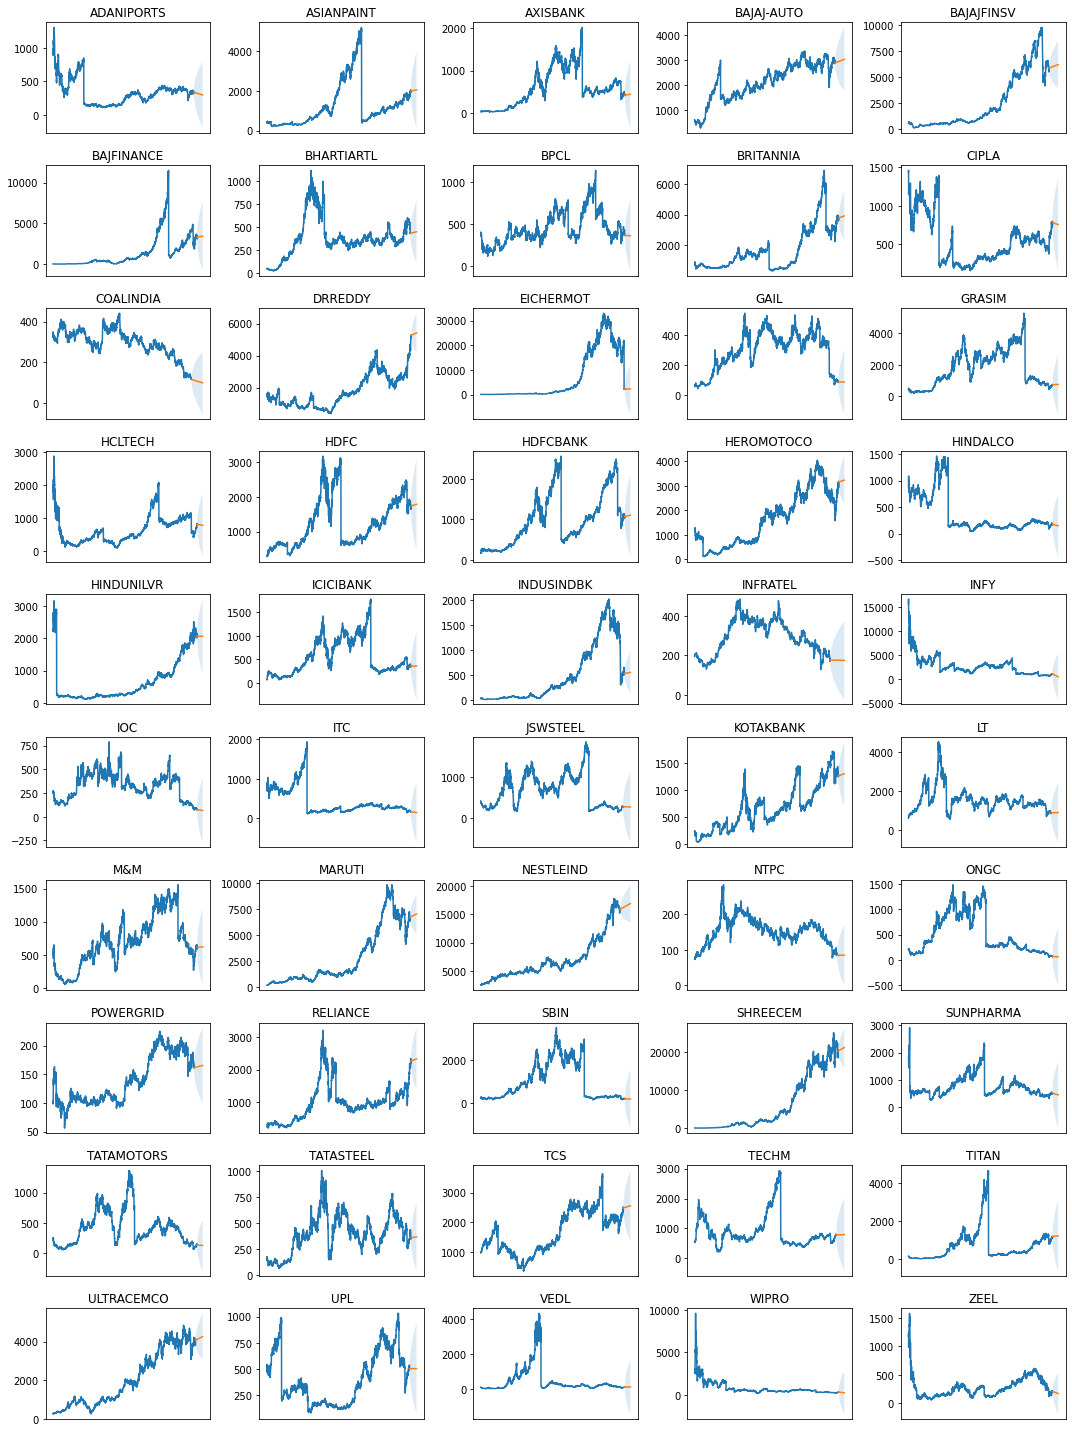

In [38]:
fig, ax = plt.subplots(10, 5, figsize=(15, 20))
for i in range(50):
    if(includema):
        forecast, b, ci = flist[i].forecast(200, alpha=0.05)
    else:
        forecast, b, ci = flist0[i].forecast(200, alpha=0.05)
    subdf = df1[df1['Symbol'] == names[i]]
    ax[i // 5, i % 5].plot(list(subdf['VWAP']))
    idx = range(len(subdf['VWAP']), 200+len(subdf['VWAP']))
    ax[i // 5, i % 5].plot(idx, forecast)
    ax[i // 5, i % 5].fill_between(idx, ci[:, 0], ci[:, 1], 
                 alpha=0.15)
    ax[i // 5, i % 5].set_title(names[i])
    ax[i // 5, i % 5].set_xticks([])
fig.tight_layout()
plt.savefig('p5.png')

In [39]:
import pmdarima as paim
subdf = df1[df1['Symbol'] == names[0]]
m1 = paim.auto_arima(subdf['VWAP'], start_p=1, start_q=1, test='adf',
                     max_p=3, max_q=3)

In [40]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3179
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -13346.144
Date:                Thu, 12 Nov 2020   AIC                          26700.287
Time:                        13:19:42   BIC                          26724.545
Sample:                             0   HQIC                         26708.987
                               - 3179                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1366      1.144      0.993      0.321      -1.106       3.379
ar.L1          0.9971      0.002    572.414      0.000       0.994       1.001
ma.L1          0.0892      0.005     16.587      0.000       0.079       0.100
sigma2       259.0152      0.418    619.397      0.000     258.196     259.835
===================================================================================
Ljung-Box (Q):                       52.63   Jarque-Bera (JB):         120511061.15
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                           -22.97
Prob(H) (two-sided):                  0.00   Kurtosis:                       955.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
subdf = df1[df1['Symbol'] == names[1]]
m2 = paim.auto_arima(subdf['VWAP'], start_p=1, start_q=1, test='adf',
                     max_p=3, max_q=3)
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5163
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -29072.936
Date:                Thu, 12 Nov 2020   AIC                          58147.873
Time:                        13:23:31   BIC                          58154.422
Sample:                             0   HQIC                         58150.164
                               - 5163                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4564.8605      1.982   2303.040      0.000    4560.976    4568.745
===================================================================================
Ljung-Box (Q):                       42.98   Jarque-Bera (JB):        3632346684.27
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               4.65   Skew:                           -60.55
Prob(H) (two-sided):                  0.00   Kurtosis:                      4110.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
subdf = df1[df1['Symbol'] == names[7]]
m3 = paim.auto_arima(subdf['VWAP'], start_p=1, start_q=1, test='adf',
                     max_p=3, max_q=3, error_action='ignore')
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5163
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -21047.069
Date:                Thu, 12 Nov 2020   AIC                          42102.139
Time:                        13:30:30   BIC                          42128.335
Sample:                             0   HQIC                         42111.305
                               - 5163                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9703      0.019     51.948      0.000       0.934       1.007
ma.L1         -0.9021      0.020    -45.739      0.000      -0.941      -0.863
ma.L2         -0.0779      0.008    -10.104      0.000      -0.093      -0.063
sigma2       203.7130      0.511    398.595      0.000     202.711     204.715
===================================================================================
Ljung-Box (Q):                       31.14   Jarque-Bera (JB):          97447842.12
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               5.01   Skew:                           -18.28
Prob(H) (two-sided):                  0.00   Kurtosis:                       675.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""